In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

import os
import sys
parent_dir = os.path.dirname(os.getcwd())  
sys.path.append(parent_dir)
from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

import jPCA

In [2]:
hand_vel = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/hand_vel.npy')
torques = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/torques.npy')
aug_behaviour = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/aug_behaviour.npy')

train_spikes = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_spksmth.npy').swapaxes(1,2)
psth = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)

In [18]:
aug_behaviour.shape

(108, 6, 35)

In [11]:
hand_vel.shape

(108, 2, 35)

In [16]:
num_conditions, _, num_time_points = hand_vel.shape
position_data = np.zeros_like(hand_vel)

dt = 1e-3
for i in range(1, num_time_points):
    position_data[:, :, i] = position_data[:, :, i - 1] + hand_vel[:, :, i] #* dt

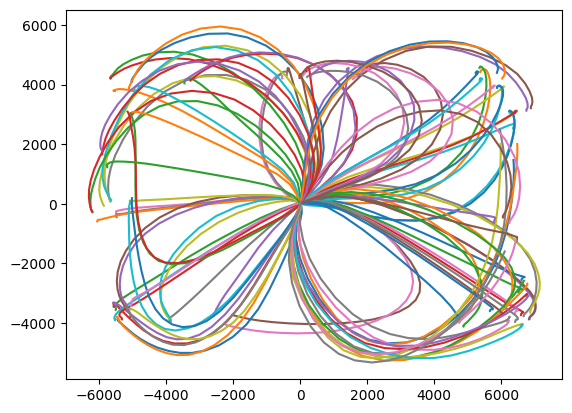

In [17]:
for i in range(108):
    plt.plot(position_data[i, 0,:], position_data[i, 1, :])

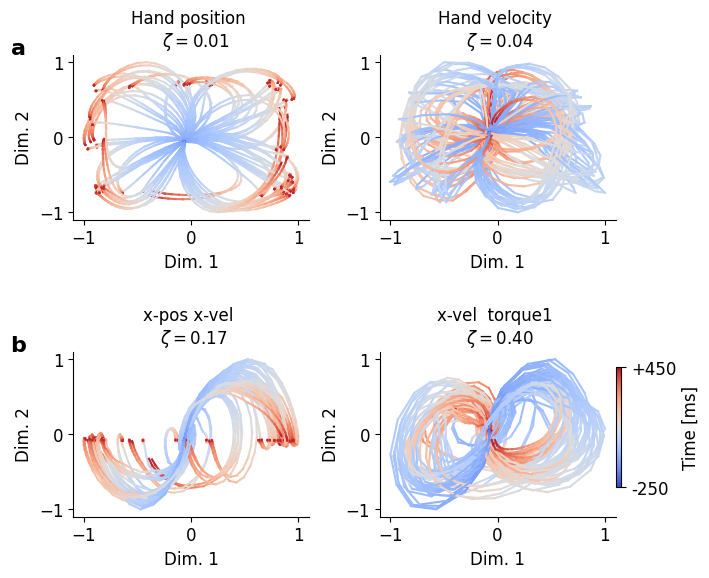

In [63]:
fig, axs = plt.subplots(2,2, figsize=(7,6)) #(11,6)

fontsize = 12


def plot_2D(ax, Y, fontsize=fontsize):
    cmap = plt.get_cmap('coolwarm')
    num_time_points = Y.shape[-1]
    
    for i in range(Y.shape[0]):
        x = Y[i, 0, :]
        y = Y[i, 1, :]
        for t in range(num_time_points - 1):
            ax.plot(x[t:t+2], y[t:t+2], color=cmap(t / (num_time_points - 1)))
    ax.set_xlabel('Dim. 1', fontsize=fontsize)
    ax.set_ylabel('Dim. 2', fontsize=fontsize)


plot_2D(axs[0,0], aug_behaviour[:,0:2,:], fontsize=fontsize)
zeta = np.abs(compute_S_all_pairs(jnp.array(center(aug_behaviour[:,0:2,:]))))
axs[0, 0].set_title(f'Hand position \n  $\\zeta = {zeta:.2f}$', fontsize=fontsize)

plot_2D(axs[0,1], aug_behaviour[:,2:4,:], fontsize=fontsize)
zeta = np.abs(compute_S_all_pairs(jnp.array(center(aug_behaviour[:,2:4,:]))))
axs[0, 1].set_title(f'Hand velocity \n $\\zeta = {zeta:.2f}$', fontsize=fontsize)


# axs[0,2].plot(torques[0,0,:], color='black')
# axs[0,2].plot(torques[0,1,:], color='black')
# axs[0,2].set_title('Torques', fontsize=fontsize)
# times = np.arange(-250, 450, 20).tolist()   
# total_range = 450 + 250  
# step = total_range / (len(times) - 1)  # Step size between each index
# indices = np.round((np.array([-250, 0, 450]) + 250) / step).astype(int)
# axs[0,2].set_xticks(indices)
# axs[0,2].set_xticklabels(['-250', 'mov', '450'])
# axs[0,2].set_xlabel('Time [ms]', fontsize=fontsize)

ids = [0, 2]
plot_2D(axs[1,0], aug_behaviour[:,ids,:], fontsize=fontsize)
zeta = np.abs(compute_S_all_pairs(jnp.array(center(aug_behaviour[:,ids,:]))))
axs[1, 0].set_title(f'x-pos x-vel \n $\\zeta = {zeta:.2f}$', fontsize=fontsize)

ids = [2, 4]
plot_2D(axs[1,1], aug_behaviour[:,ids,:], fontsize=fontsize)
zeta = np.abs(compute_S_all_pairs(jnp.array(center(aug_behaviour[:,ids,:]))))
axs[1, 1].set_title(f'x-vel  torque1 \n $\\zeta = {zeta:.2f}$', fontsize=fontsize)

#axs[1,2].axis('off')

for ax in axs.flatten():
    ax.spines[['top','right']].set_visible(False)
    ax.tick_params(axis='both', labelsize=fontsize)

for i, label in enumerate(['a', 'b']):
    axs[i, 0].text(-0.2, 1.1, label, transform=axs[i, 0].transAxes, fontsize=fontsize+4, fontweight='bold', va='top', ha='right')

cbar_ax = fig.add_axes([0.9, 0.16, 0.008, 0.2])  
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-250, vmax=450)), cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-250, 450])
cbar.set_ticklabels(['-250', '+450'], fontsize=fontsize)
cbar.set_label('Time [ms]', fontsize=fontsize)

plt.subplots_adjust(wspace=0.3, hspace=0.8)